In [1]:
%matplotlib notebook
from IPython.display import Image, IFrame

# Case: VRE workflow in a core field study

### Mikkel Otzen, DTU Space

__Geostatistical Simulation and Probabilistic Inversion in Geomagnetism__

In measurements of the magnetic field I will attempt to distinguish signatures originating from the magnetized lithosphere from signatures generated by currents in the core

- Today: Geostatistical simulation of the core field with VRE

__Experience with Swarm observations__

- Research until recently focused on model validation with synthetic observations
- Sets of observations based on CHAOS-6 selection criteria
- VirES VRE as first hands on experience


## Linear inverse problem

In spherical geometry, given observations, d(__r__), and model parameters on a spherical surface, m(__s__), related through an integrating kernel $\mathcal{G}$(__r__,__s__) we consider a linear inverse problem of the form

d(__r__) = $\int_{S} \mathcal{G}$(__r__,__s__) m(__s__) $dS$

- $dS = \sin \theta_s d\theta_s d\phi_s$
- __r__ = $(r,\theta,\phi)$, locations of observations
- __s__ = $(R,\theta_s,\phi_s)$, locations of model parameters on a spherical surface of radius $R$ 
- $\mathcal{G}$(__r__,__s__) is based on exterior Green's functions for Laplace's equation with Neumann boundary conditions
- Links the geomagnetic field at an observation location, __r__, to the radial field at a source location, __s__.

In [2]:
IFrame('images/implementation_geometry_simple_ex.pdf', width=600, height=600)

## Core field study

At the core-mantle boundary estimate posterior pdf, __m__

- Collection of model parameter values on the spherical surface grid
- Estimation based on observations and prior information on the model parameters

## Method 
#### Direct Sequential Simulation

- Well known geostatistical method usually used in underground natural resource exploration
- Non-Gaussian
- Reproduces (conditional on observations)
    - Prior covariance model
    - Training image histogram (dynamo simulation)
- Implementation in spherical geometry / active research


# Case study goal

#### Use VirES VRE to get magnetic data + models and carry out the outlined core field study

This means...
- Swarm observations of the radial field
- Models of the lithosphere, magnetosphere, and ionosphere to subtract from the observations
- Run my implementation


## Run my preliminaries

In [2]:
from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Showcase VirES VRE workflow with SDSSIM"
nb_name = "nb_seqsim_core_swarm_dqw"

In [3]:
shn = 30
C_e_const = 2.0

core = SDSS(comment, N_SH = shn, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shn, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)

core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 101, rangv_lim = 2.0, rangv_N = 101)

core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)


____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



In [5]:
#Image(filename='images/sdssim_outline.png') 
#mt_util.plot_global(lat = core.lat, lon = core.lon, data=core.data, limits_data = [-1,1],
#                cbar_h = 0.075, unit_transform_n_to_m = True,
#                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
#                bottom=0.35, top=0.95, hspace=0.01,
#                title='Training image (dynamo simulation)', point_size=1,
#                savefig = False, save_dpi = 100, save_string ="vre_obs_TI",
#                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# Swarm observations through VirES VRE

In [4]:
import datetime as dt
from viresclient import SwarmRequest

request = SwarmRequest()

In [5]:
#request.available_collections()

In [5]:
collect = "SW_OPER_MAGA_LR_1B"

In [6]:
request.available_measurements("MAG")

['F',
 'dF_AOCS',
 'dF_other',
 'F_error',
 'B_VFM',
 'B_NEC',
 'dB_Sun',
 'dB_AOCS',
 'dB_other',
 'B_error',
 'q_NEC_CRF',
 'Att_error',
 'Flags_F',
 'Flags_B',
 'Flags_q',
 'Flags_Platform',
 'ASM_Freq_Dev']

In [7]:
use_meas = ["B_NEC"]

In [9]:
request.available_auxiliaries()

['Timestamp',
 'Latitude',
 'Longitude',
 'Radius',
 'Spacecraft',
 'OrbitDirection',
 'QDOrbitDirection',
 'SyncStatus',
 'Kp10',
 'Kp',
 'Dst',
 'F107',
 'IMF_BY_GSM',
 'IMF_BZ_GSM',
 'IMF_V',
 'F10_INDEX',
 'OrbitSource',
 'OrbitNumber',
 'AscendingNodeTime',
 'AscendingNodeLongitude',
 'QDLat',
 'QDLon',
 'QDBasis',
 'MLT',
 'SunDeclination',
 'SunHourAngle',
 'SunRightAscension',
 'SunAzimuthAngle',
 'SunZenithAngle',
 'SunLongitude',
 'SunVector',
 'DipoleAxisVector',
 'NGPLatitude',
 'NGPLongitude',
 'DipoleTiltAngle']

In [8]:
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst"] # IMF

In [11]:
request.available_models(details=False)

['IGRF',
 'LCS-1',
 'MF7',
 'CHAOS-Core',
 'CHAOS-Static',
 'CHAOS-MMA-Primary',
 'CHAOS-MMA-Secondary',
 'MCO_SHA_2C',
 'MCO_SHA_2D',
 'MLI_SHA_2C',
 'MLI_SHA_2D',
 'MLI_SHA_2E',
 'MMA_SHA_2C-Primary',
 'MMA_SHA_2C-Secondary',
 'MMA_SHA_2F-Primary',
 'MMA_SHA_2F-Secondary',
 'MIO_SHA_2C-Primary',
 'MIO_SHA_2C-Secondary',
 'MIO_SHA_2D-Primary',
 'MIO_SHA_2D-Secondary',
 'AMPS',
 'MCO_SHA_2X',
 'CHAOS',
 'CHAOS-MMA',
 'MMA_SHA_2C',
 'MMA_SHA_2F',
 'MIO_SHA_2C',
 'MIO_SHA_2D',
 'SwarmCI']

In [9]:
use_models = ["M_use = 'LCS-1' + 'CHAOS-MMA-Primary' + 'CHAOS-MMA-Secondary' + 'MIO_SHA_2C'"]

In [10]:
request.set_collection(collect)

request.set_products(measurements=use_meas,
                     models=use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step="PT5M")

data = request.get_between(start_time=dt.datetime(2016,1,1),
                           end_time=dt.datetime(2016,1,15))

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:08, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.477MB)


In [11]:
ds = data.as_xarray()
print(ds)

<xarray.Dataset>
Dimensions:         (NEC: 3, Timestamp: 4032)
Coordinates:
  * Timestamp       (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-14T23:55:00
  * NEC             (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft      (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    Longitude       (Timestamp) float64 92.79 -151.7 -105.0 ... -111.8 -112.1
    Latitude        (Timestamp) float64 -72.5 -86.75 -68.79 ... 5.754 24.98
    QDLat           (Timestamp) float64 -81.08 -74.82 -57.12 ... 12.4 32.03
    Kp              (Timestamp) float64 5.7 6.0 6.0 6.0 6.0 ... 2.7 2.7 2.7 2.7
    SunZenithAngle  (Timestamp) float64 67.46 64.1 63.79 ... 59.87 67.8 77.79
    Dst             (Timestamp) float64 -101.5 -102.9 -104.3 ... -13.0 -13.0
    Radius          (Timestamp) float64 6.834e+06 6.834e+06 ... 6.824e+06
    B_NEC           (Timestamp, NEC) float64 -1.581e+03 -1.049e+04 ... 2.708e+04
    B_NEC_M_use     (Timestamp, NEC) float64 -22.99 -1.688 -67.5 ... 4.589 9.819
Attr

<IPython.core.display.Javascript object>


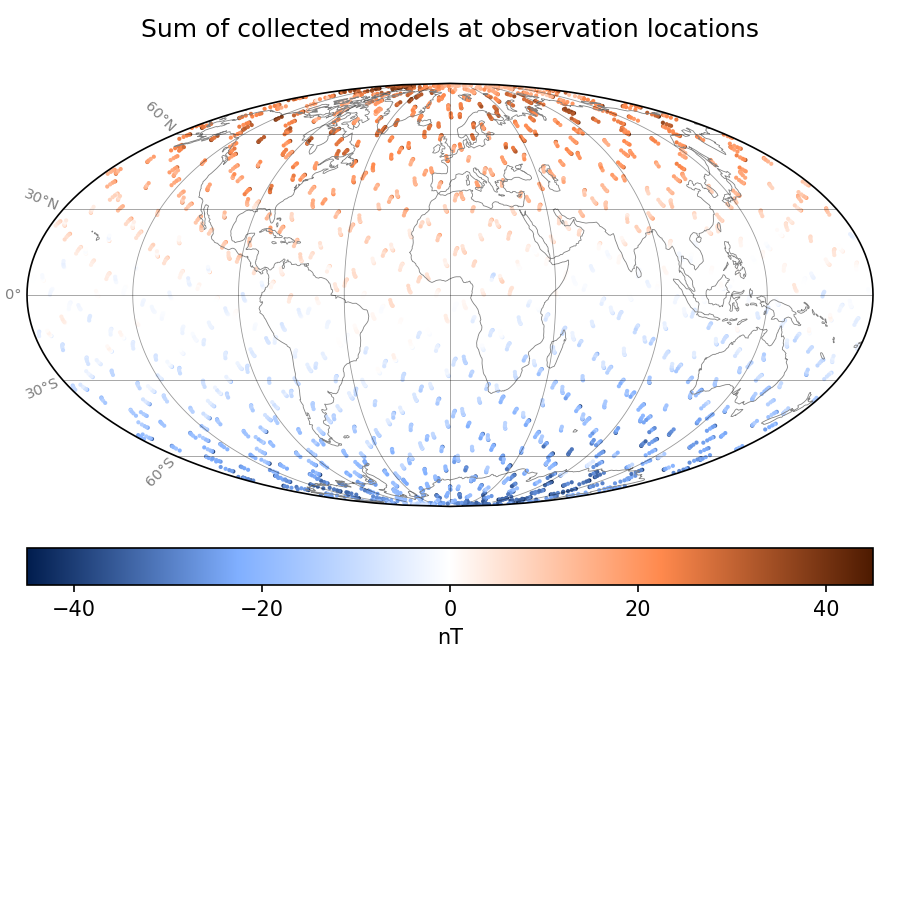

In [12]:
mt_util.plot_global(lat = ds.Latitude.values, lon = ds.Longitude.values, data=ds["B_NEC_M_use"].values[:,2], 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Sum of collected models at observation locations', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [16]:
SZA_angle = 10
Kp_max = 2
dDst_max = 2
QDlat_max = 55

# Index sorting to get rid of observations that do not live up to the set criteria
idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, abs(np.diff(ds.Dst.values,prepend=0))/(5/60) <=dDst_max))

In [17]:
obs_sat = SDSS(comment, N_SH = shn)

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] #+ ds["B_NEC_M_use"].values[:,2][idx_sort] 

obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.data)
print(obs_sat.grid_N)

838


<IPython.core.display.Javascript object>


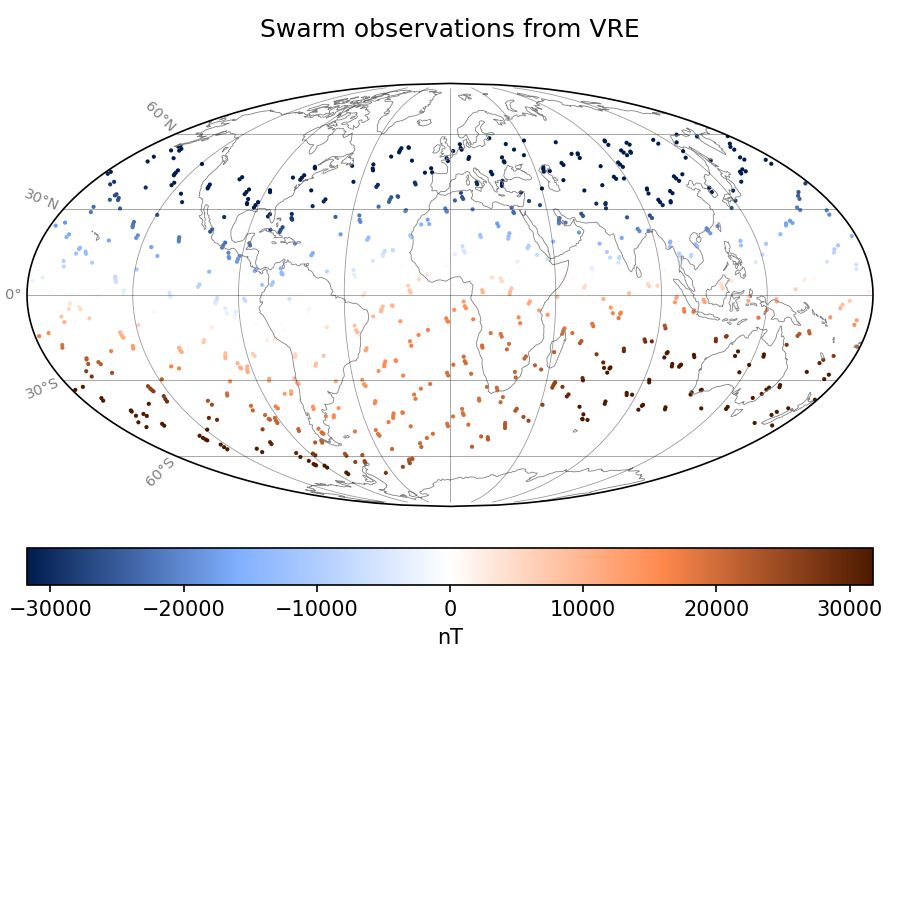

In [18]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=obs_sat.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Swarm observations from VRE', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# Kernel

In [19]:
core.grid_glq(nmax = shn, r_at = core.r_cmb)
core.integrating_kernel(obs_sat, C_e_const = C_e_const)

# Equivalent LSQ solution

In [20]:
core.covmod_lsq_equiv(obs_sat.data, core.C_mm_all, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


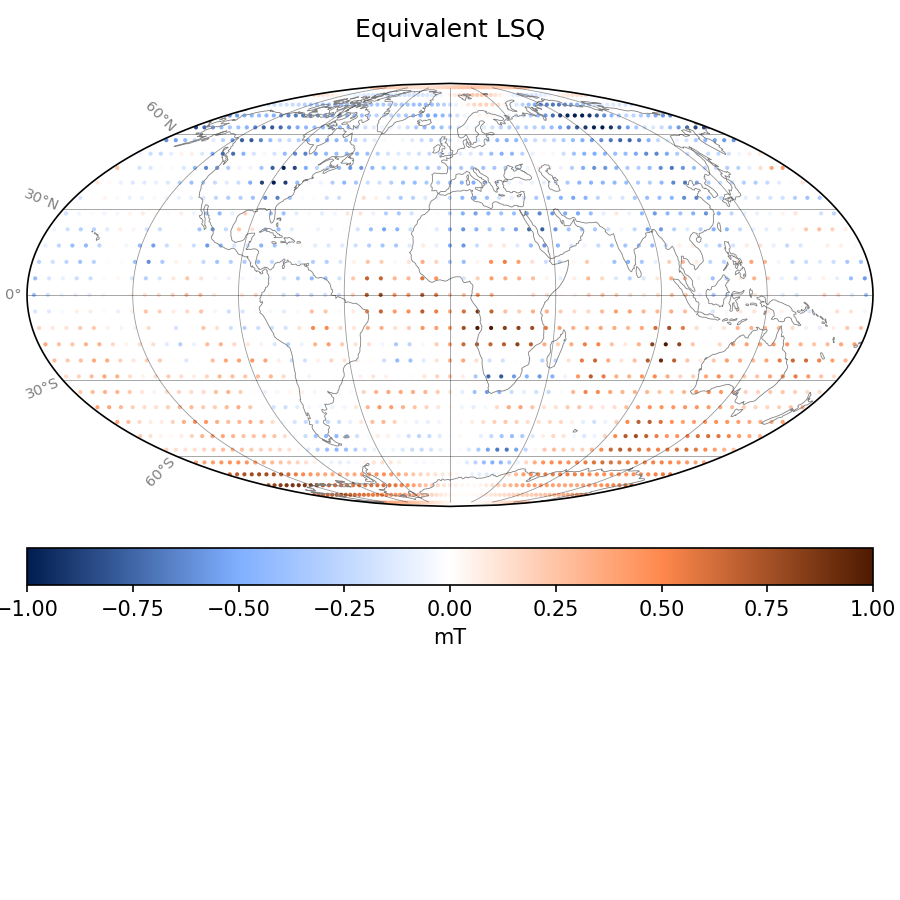

In [21]:
mt_util.plot_global(lat = core.lat, lon = core.lon, data=np.ravel(core.m_equiv_lsq), limits_data = [-1,1],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_lsq",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# Removing modelled signatures

In [22]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
core.ensemble_B(core.g_lsq_equiv, nmax = shn, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble[:,0].copy()

In [23]:
core.grid_glq(nmax = shn, r_at = core.r_cmb)



# Model removal
obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] + ds["B_NEC_M_use"].values[:,2][idx_sort] 



core.covmod_lsq_equiv(obs_sat.data, core.C_mm_all, core.G, core.r_cmb)
core.grid_glq(nmax = 256, r_at = core.r_cmb)
core.ensemble_B(core.g_lsq_equiv, nmax = shn, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa_m_use = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


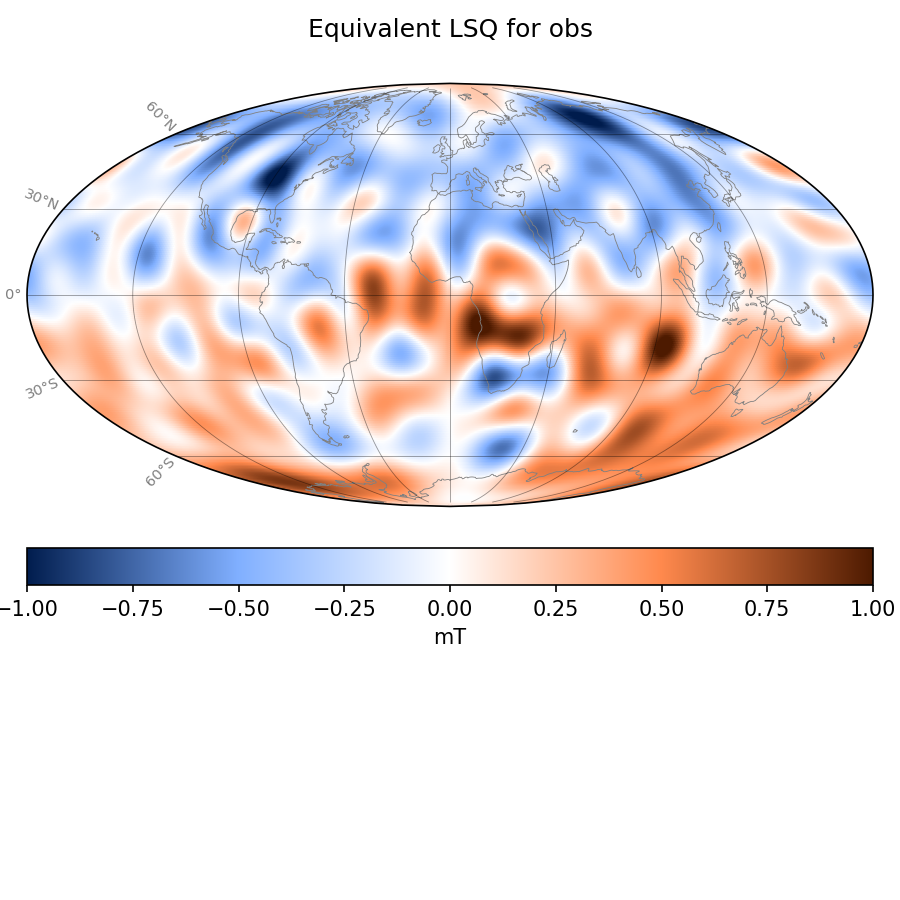

<IPython.core.display.Javascript object>


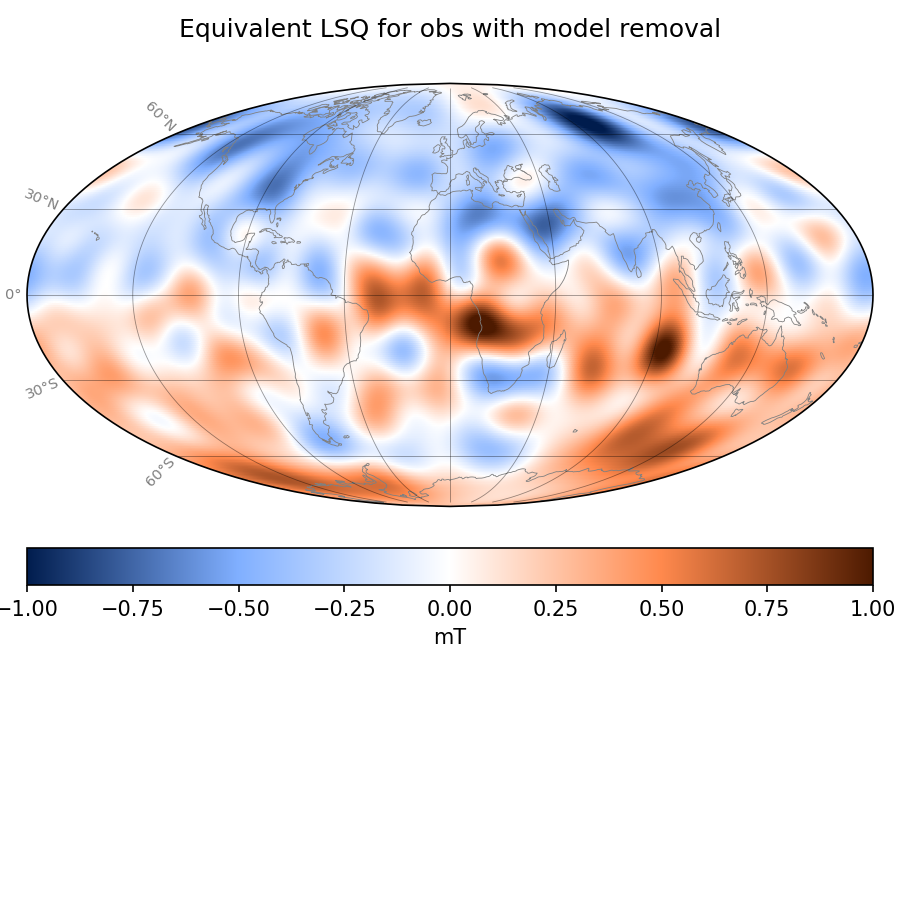

In [24]:
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=lsq_eqa, limits_data = [-1,1],
                cbar_h = 0.075, cbar_mm_factor = 3/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ for obs', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_lsq",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=lsq_eqa_m_use, limits_data = [-1,1],
                cbar_h = 0.075, cbar_mm_factor = 3/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ for obs with model removal', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_lsq",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.grid_glq(nmax = shn, r_at = core.r_cmb)

...

...

## Simulation cooked last night...

In [ ]:
#SZA_angle = 10
#Kp_max = 2
#dDst_max = 2
#QDlat_max = 55

# With model removal

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.177 minutes 
Total elapsed time: 2.177 minutes 
Variance: 172049172049.183
Mean: 4080.271
Max: 1269917.114
Min: -1314429.043
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.136 minutes 
Total elapsed time: 4.313 minutes 
Variance: 175888982531.852
Mean: 9798.014
Max: 1706694.637
Min: -1405481.405
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.125 minutes 
Total elapsed time: 6.438 minutes 
Variance: 180800638382.832
Mean: 4995.925
Max: 1640014.239
Min: -1393036.041
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.055 minutes 
Total elapsed time: 8.493 minutes 
Variance: 172320504822.372
Mean: 3355.271
Max: 1741277.388
Min: -1325891.191
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr. 4

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.010 minutes 
Total elapsed time: 1.180 hours 
Variance: 176491183401.698
Mean: 10576.334
Max: 1774887.914
Min: -1536851.084
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.008 minutes 
Total elapsed time: 1.213 hours 
Variance: 177549198977.287
Mean: 9879.346
Max: 1445022.564
Min: -1203805.532
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.021 minutes 
Total elapsed time: 1.247 hours 
Variance: 179073591951.050
Mean: 6248.220
Max: 1609602.970
Min: -1445629.957
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.021 minutes 
Total elapsed time: 1.280 hours 
Variance: 178846855379.220
Mean: 6785.757
Max: 1446847.617
Min: -1403153.194
Run nr.: 38

 |OOOOOOOOOO| 100.0%   realization nr. 

 |OOOOOOOOOO| 100.0%   realization nr. 68. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.021 minutes 
Total elapsed time: 2.322 hours 
Variance: 179382092376.267
Mean: 6688.689
Max: 1868750.016
Min: -1526090.076
Run nr.: 69

 |OOOOOOOOOO| 100.0%   realization nr. 69. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.931 minutes 
Total elapsed time: 2.354 hours 
Variance: 179966293253.429
Mean: 10793.484
Max: 1791994.474
Min: -1601643.833
Run nr.: 70

 |OOOOOOOOOO| 100.0%   realization nr. 70. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.085 minutes 
Total elapsed time: 2.389 hours 
Variance: 183216028415.647
Mean: 11501.366
Max: 1811863.845
Min: -1595938.723
Run nr.: 71

 |OOOOOOOOOO| 100.0%   realization nr. 71. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.112 minutes 
Total elapsed time: 2.424 hours 
Variance: 177798291884.557
Mean: 10728.769
Max: 1284315.360
Min: -1311738.331
Run nr.: 72

 |OOOOOOOOOO| 100.0%   realization nr

 |OOOOOOOOOO| 100.0%   realization nr. 102. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.365 minutes 
Total elapsed time: 3.741 hours 
Variance: 180105883012.215
Mean: 15167.590
Max: 1471040.334
Min: -2734837.218
Run nr.: 103

 |OOOOOOOOOO| 100.0%   realization nr. 103. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.060 minutes 
Total elapsed time: 3.775 hours 
Variance: 179584628810.473
Mean: 10608.588
Max: 2105295.057
Min: -1300609.886
Run nr.: 104

 |OOOOOOOOOO| 100.0%   realization nr. 104. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.072 minutes 
Total elapsed time: 3.810 hours 
Variance: 167847396207.076
Mean: 11096.663
Max: 1643551.390
Min: -1377915.257
Run nr.: 105

 |OOOOOOOOOO| 100.0%   realization nr. 105. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.032 minutes 
Total elapsed time: 3.844 hours 
Variance: 185988603394.315
Mean: 16995.655
Max: 2237703.656
Min: -1580378.063
Run nr.: 106

 |OOOOOOOOOO| 100.0%   reali

 |OOOOOOOOOO| 100.0%   realization nr. 136. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.020 minutes 
Total elapsed time: 4.899 hours 
Variance: 182152480668.787
Mean: 8236.580
Max: 1719151.092
Min: -1555948.044
Run nr.: 137

 |OOOOOOOOOO| 100.0%   realization nr. 137. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.031 minutes 
Total elapsed time: 4.933 hours 
Variance: 184619804341.846
Mean: 577.525
Max: 1533778.293
Min: -1277443.605
Run nr.: 138

 |OOOOOOOOOO| 100.0%   realization nr. 138. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.049 minutes 
Total elapsed time: 4.967 hours 
Variance: 183173971277.174
Mean: 2616.797
Max: 1795480.260
Min: -1295494.669
Run nr.: 139

 |OOOOOOOOOO| 100.0%   realization nr. 139. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.018 minutes 
Total elapsed time: 5.000 hours 
Variance: 183115988916.078
Mean: 3331.774
Max: 1498801.812
Min: -1688353.693
Run nr.: 140

 |OOOOOOOOOO| 100.0%   realizatio

 |OOOOOOOOOO| 100.0%   realization nr. 170. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.023 minutes 
Total elapsed time: 6.051 hours 
Variance: 183247199391.792
Mean: 8885.205
Max: 2275790.202
Min: -1387684.809
Run nr.: 171

 |OOOOOOOOOO| 100.0%   realization nr. 171. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.038 minutes 
Total elapsed time: 6.085 hours 
Variance: 172039551660.768
Mean: 9392.981
Max: 1364995.119
Min: -1249938.266
Run nr.: 172

 |OOOOOOOOOO| 100.0%   realization nr. 172. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.049 minutes 
Total elapsed time: 6.119 hours 
Variance: 177355580197.282
Mean: 6145.257
Max: 1253250.185
Min: -1270420.406
Run nr.: 173

 |OOOOOOOOOO| 100.0%   realization nr. 173. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.059 minutes 
Total elapsed time: 6.154 hours 
Variance: 168895874566.619
Mean: 13716.454
Max: 1250768.305
Min: -1271845.945
Run nr.: 174

 |OOOOOOOOOO| 100.0%   realizat

 |OOOOOOOOOO| 100.0%   realization nr. 204. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.037 minutes 
Total elapsed time: 7.207 hours 
Variance: 181051955129.099
Mean: 4802.449
Max: 1563380.007
Min: -1569467.127
Run nr.: 205

 |OOOOOOOOOO| 100.0%   realization nr. 205. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.025 minutes 
Total elapsed time: 7.241 hours 
Variance: 179502591768.925
Mean: 9686.304
Max: 1422191.562
Min: -2742294.744
Run nr.: 206

 |OOOOOOOOOO| 100.0%   realization nr. 206. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.068 minutes 
Total elapsed time: 7.275 hours 
Variance: 173709876534.058
Mean: 12164.890
Max: 1530288.158
Min: -1474960.949
Run nr.: 207

 |OOOOOOOOOO| 100.0%   realization nr. 207. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.046 minutes 
Total elapsed time: 7.309 hours 
Variance: 177887207515.919
Mean: 588.022
Max: 1990336.966
Min: -1286372.080
Run nr.: 208

 |OOOOOOOOOO| 100.0%   realizati

 |OOOOOOOOOO| 100.0%   realization nr. 238. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.026 minutes 
Total elapsed time: 8.364 hours 
Variance: 183997314728.527
Mean: 5784.348
Max: 1297844.045
Min: -2471073.125
Run nr.: 239

 |OOOOOOOOOO| 100.0%   realization nr. 239. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.049 minutes 
Total elapsed time: 8.398 hours 
Variance: 174997708253.746
Mean: 413.374
Max: 1790546.482
Min: -1528872.390
Run nr.: 240

 |OOOOOOOOOO| 100.0%   realization nr. 240. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.035 minutes 
Total elapsed time: 8.432 hours 
Variance: 167291364637.478
Mean: 6872.255
Max: 1377653.500
Min: -1635840.567
Run nr.: 241

 |OOOOOOOOOO| 100.0%   realization nr. 241. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.034 minutes 
Total elapsed time: 8.466 hours 
Variance: 171212121232.310
Mean: 9356.952
Max: 1781541.780
Min: -1496740.184
Run nr.: 242

 |OOOOOOOOOO| 100.0%   realizatio

 |OOOOOOOOOO| 100.0%   realization nr. 272. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.032 minutes 
Total elapsed time: 9.518 hours 
Variance: 173161376636.932
Mean: 9222.620
Max: 1580552.161
Min: -1251468.803
Run nr.: 273

 |OOOOOOOOOO| 100.0%   realization nr. 273. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 1.996 minutes 
Total elapsed time: 9.551 hours 
Variance: 176782116671.290
Mean: 8907.744
Max: 1942651.640
Min: -1835887.108
Run nr.: 274

 |OOOOOOOOOO| 100.0%   realization nr. 274. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.043 minutes 
Total elapsed time: 9.585 hours 
Variance: 178324358349.245
Mean: 11592.898
Max: 2265069.157
Min: -1283996.720
Run nr.: 275

 |OOOOOOOOOO| 100.0%   realization nr. 275. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.044 minutes 
Total elapsed time: 9.619 hours 
Variance: 170874812076.963
Mean: 8076.296
Max: 1551441.558
Min: -1309412.799
Run nr.: 276

 |OOOOOOOOOO| 100.0%   realizat

 |OOOOOOOOOO| 100.0%   realization nr. 306. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.046 minutes 
Total elapsed time: 10.674 hours 
Variance: 171988642326.874
Mean: 4389.130
Max: 1695879.351
Min: -1146784.176
Run nr.: 307

 |OOOOOOOOOO| 100.0%   realization nr. 307. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.042 minutes 
Total elapsed time: 10.709 hours 
Variance: 175261730185.726
Mean: 11656.980
Max: 2017617.129
Min: -1464615.175
Run nr.: 308

 |OOOOOOOOOO| 100.0%   realization nr. 308. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.059 minutes 
Total elapsed time: 10.743 hours 
Variance: 179047338102.767
Mean: 6805.611
Max: 1416881.954
Min: -2731877.584
Run nr.: 309

 |OOOOOOOOOO| 100.0%   realization nr. 309. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.038 minutes 
Total elapsed time: 10.777 hours 
Variance: 181728389978.551
Mean: 8820.701
Max: 1436044.062
Min: -1407009.968
Run nr.: 310

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 340. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.034 minutes 
Total elapsed time: 11.828 hours 
Variance: 180733489604.850
Mean: 7914.135
Max: 2103847.126
Min: -2564471.583
Run nr.: 341

 |OOOOOOOOOO| 100.0%   realization nr. 341. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.048 minutes 
Total elapsed time: 11.862 hours 
Variance: 171590211955.534
Mean: 5527.243
Max: 1262626.863
Min: -1273498.238
Run nr.: 342

 |OOOOOOOOOO| 100.0%   realization nr. 342. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.066 minutes 
Total elapsed time: 11.896 hours 
Variance: 171100612536.266
Mean: 7858.071
Max: 2091345.602
Min: -1652343.418
Run nr.: 343

 |OOOOOOOOOO| 100.0%   realization nr. 343. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.070 minutes 
Total elapsed time: 11.931 hours 
Variance: 179350063749.759
Mean: 10088.562
Max: 1745420.000
Min: -1483741.244
Run nr.: 344

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 374. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.018 minutes 
Total elapsed time: 12.982 hours 
Variance: 174810546221.745
Mean: 8170.956
Max: 1355067.298
Min: -1713920.352
Run nr.: 375

 |OOOOOOOOOO| 100.0%   realization nr. 375. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.049 minutes 
Total elapsed time: 13.016 hours 
Variance: 166174313378.139
Mean: 5830.188
Max: 1270278.102
Min: -1341362.191
Run nr.: 376

 |OOOOOOOOOO| 100.0%   realization nr. 376. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.061 minutes 
Total elapsed time: 13.050 hours 
Variance: 179891582723.795
Mean: 9980.486
Max: 1275744.840
Min: -1697808.297
Run nr.: 377

 |OOOOOOOOOO| 100.0%   realization nr. 377. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.053 minutes 
Total elapsed time: 13.085 hours 
Variance: 176353227680.640
Mean: 3059.262
Max: 1402305.849
Min: -1343759.085
Run nr.: 378

 |OOOOOOOOOO| 100.0%   reali

 |OOOOOOOOOO| 100.0%   realization nr. 408. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.023 minutes 
Total elapsed time: 14.135 hours 
Variance: 179687798287.797
Mean: 14471.268
Max: 2135660.761
Min: -1436113.918
Run nr.: 409

 |OOOOOOOOOO| 100.0%   realization nr. 409. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.030 minutes 
Total elapsed time: 14.169 hours 
Variance: 180820016296.800
Mean: 7446.938
Max: 1195219.085
Min: -1356269.565
Run nr.: 410

 |OOOOOOOOOO| 100.0%   realization nr. 410. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.018 minutes 
Total elapsed time: 14.202 hours 
Variance: 175013361081.639
Mean: 6999.617
Max: 1502035.653
Min: -1380862.821
Run nr.: 411

 |OOOOOOOOOO| 100.0%   realization nr. 411. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.007 minutes 
Total elapsed time: 14.236 hours 
Variance: 177036570446.624
Mean: 5862.405
Max: 1309701.301
Min: -1363387.181
Run nr.: 412

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 442. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.025 minutes 
Total elapsed time: 15.287 hours 
Variance: 177045527428.093
Mean: 6697.775
Max: 1931051.123
Min: -1401314.755
Run nr.: 443

 |OOOOOOOOOO| 100.0%   realization nr. 443. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.036 minutes 
Total elapsed time: 15.321 hours 
Variance: 173488659500.202
Mean: 13690.628
Max: 1893869.859
Min: -1427122.435
Run nr.: 444

 |OOOOOOOOOO| 100.0%   realization nr. 444. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.029 minutes 
Total elapsed time: 15.355 hours 
Variance: 170887150359.929
Mean: 6515.770
Max: 1412431.438
Min: -1380631.041
Run nr.: 445

 |OOOOOOOOOO| 100.0%   realization nr. 445. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.043 minutes 
Total elapsed time: 15.389 hours 
Variance: 174784844015.114
Mean: 6596.914
Max: 1675696.604
Min: -1209631.478
Run nr.: 446

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 476. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.088 minutes 
Total elapsed time: 16.446 hours 
Variance: 171410889021.000
Mean: 1167.729
Max: 1261377.753
Min: -1291060.288
Run nr.: 477

 |OOOOOOOOOO| 100.0%   realization nr. 477. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.060 minutes 
Total elapsed time: 16.481 hours 
Variance: 180778842909.269
Mean: 6022.479
Max: 2016547.223
Min: -1429810.940
Run nr.: 478

 |OOOOOOOOOO| 100.0%   realization nr. 478. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.058 minutes 
Total elapsed time: 16.515 hours 
Variance: 200798368802.269
Mean: 5878.348
Max: 1256015.451
Min: -2855373.479
Run nr.: 479

 |OOOOOOOOOO| 100.0%   realization nr. 479. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.040 minutes 
Total elapsed time: 16.549 hours 
Variance: 173565588242.211
Mean: 2855.619
Max: 1946587.675
Min: -1488126.701
Run nr.: 480

 |OOOOOOOOOO| 100.0%   reali

 |OOOOOOOOOO| 100.0%   realization nr. 510. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 1.989 minutes 
Total elapsed time: 17.585 hours 
Variance: 185021232895.282
Mean: 16845.708
Max: 1278300.384
Min: -1363194.352
Run nr.: 511

 |OOOOOOOOOO| 100.0%   realization nr. 511. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.007 minutes 
Total elapsed time: 17.618 hours 
Variance: 183396364962.513
Mean: 14599.578
Max: 1690339.172
Min: -1386242.331
Run nr.: 512

 |OOOOOOOOOO| 100.0%   realization nr. 512. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 1.942 minutes 
Total elapsed time: 17.651 hours 
Variance: 173016957927.127
Mean: 10733.271
Max: 1292799.309
Min: -1430273.385
Run nr.: 513

 |OOOOOOOOOO| 100.0%   realization nr. 513. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.008 minutes 
Total elapsed time: 17.684 hours 
Variance: 170200037543.278
Mean: 13754.900
Max: 1258912.003
Min: -1563651.273
Run nr.: 514

 |OOOOOOOOOO| 100.0%   r

 |OOOOOOOOOO| 100.0%   realization nr. 544. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.062 minutes 
Total elapsed time: 18.732 hours 
Variance: 177814653857.156
Mean: 2378.341
Max: 1896989.544
Min: -2802578.292
Run nr.: 545

 |OOOOOOOOOO| 100.0%   realization nr. 545. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.025 minutes 
Total elapsed time: 18.766 hours 
Variance: 172339837075.719
Mean: 4114.263
Max: 1449061.886
Min: -1909889.974
Run nr.: 546

 |OOOOOOOOOO| 100.0%   realization nr. 546. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.045 minutes 
Total elapsed time: 18.800 hours 
Variance: 172777672088.591
Mean: 830.523
Max: 1282497.302
Min: -1179783.907
Run nr.: 547

 |OOOOOOOOOO| 100.0%   realization nr. 547. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.024 minutes 
Total elapsed time: 18.833 hours 
Variance: 174325323978.167
Mean: 7260.215
Max: 1542119.359
Min: -2107446.920
Run nr.: 548

 |OOOOOOOOOO| 100.0%   realiz

 |OOOOOOOOOO| 100.0%   realization nr. 578. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.002 minutes 
Total elapsed time: 19.886 hours 
Variance: 177704837441.884
Mean: 313.390
Max: 1326305.123
Min: -1569577.282
Run nr.: 579

 |OOOOOOOOOO| 100.0%   realization nr. 579. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.026 minutes 
Total elapsed time: 19.920 hours 
Variance: 179331014224.162
Mean: 11358.276
Max: 1305475.664
Min: -1502310.392
Run nr.: 580

 |OOOOOOOOOO| 100.0%   realization nr. 580. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 1.994 minutes 
Total elapsed time: 19.953 hours 
Variance: 182243597274.833
Mean: 1278.088
Max: 1848232.893
Min: -1926112.321
Run nr.: 581

 |OOOOOOOOOO| 100.0%   realization nr. 581. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 1.993 minutes 
Total elapsed time: 19.986 hours 
Variance: 176097461481.849
Mean: 4111.685
Max: 1366422.949
Min: -1889328.652
Run nr.: 582

 |OOOOOOOOOO| 100.0%   reali

 |OOOOOOOOOO| 100.0%   realization nr. 612. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.011 minutes 
Total elapsed time: 21.030 hours 
Variance: 177656745844.800
Mean: 11012.416
Max: 1841316.280
Min: -1473999.333
Run nr.: 613

 |OOOOOOOOOO| 100.0%   realization nr. 613. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.036 minutes 
Total elapsed time: 21.064 hours 
Variance: 180948603231.895
Mean: 5534.536
Max: 1357983.547
Min: -1679499.324
Run nr.: 614

 |OOOOOOOOOO| 100.0%   realization nr. 614. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.004 minutes 
Total elapsed time: 21.098 hours 
Variance: 175197969555.891
Mean: 13242.506
Max: 1620914.902
Min: -1321347.676
Run nr.: 615

 |OOOOOOOOOO| 100.0%   realization nr. 615. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 1.993 minutes 
Total elapsed time: 21.131 hours 
Variance: 170549251558.321
Mean: 8633.970
Max: 1497250.384
Min: -1468602.161
Run nr.: 616

 |OOOOOOOOOO| 100.0%   rea

 |OOOOOOOOOO| 100.0%   realization nr. 646. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.031 minutes 
Total elapsed time: 22.175 hours 
Variance: 177140084515.623
Mean: 9143.349
Max: 2031560.531
Min: -1382882.202
Run nr.: 647

 |OOOOOOOOOO| 100.0%   realization nr. 647. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.022 minutes 
Total elapsed time: 22.209 hours 
Variance: 172590553961.594
Mean: 15060.360
Max: 1289175.943
Min: -1363678.671
Run nr.: 648

 |OOOOOOOOOO| 100.0%   realization nr. 648. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.014 minutes 
Total elapsed time: 22.242 hours 
Variance: 170471310694.411
Mean: 9358.068
Max: 1708535.689
Min: -1214069.552
Run nr.: 649

 |OOOOOOOOOO| 100.0%   realization nr. 649. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.028 minutes 
Total elapsed time: 22.276 hours 
Variance: 177342563532.101
Mean: 14831.635
Max: 1534031.566
Min: -1406150.406
Run nr.: 650

 |OOOOOOOOOO| 100.0%   rea

 |OOOOOOOOOO| 100.0%   realization nr. 680. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.023 minutes 
Total elapsed time: 23.324 hours 
Variance: 181851940597.173
Mean: 7610.112
Max: 1468519.994
Min: -1381954.296
Run nr.: 681

 |OOOOOOOOOO| 100.0%   realization nr. 681. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.039 minutes 
Total elapsed time: 23.358 hours 
Variance: 168677128590.314
Mean: 1352.946
Max: 1211261.861
Min: -1291785.383
Run nr.: 682

 |OOOOOOOOOO| 100.0%   realization nr. 682. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.044 minutes 
Total elapsed time: 23.392 hours 
Variance: 181520042970.725
Mean: 8034.131
Max: 2076765.774
Min: -1380875.982
Run nr.: 683

 |OOOOOOOOOO| 100.0%   realization nr. 683. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.016 minutes 
Total elapsed time: 23.425 hours 
Variance: 184285371616.965
Mean: 939.180
Max: 1470630.351
Min: -2816378.172
Run nr.: 684

 |OOOOOOOOOO| 100.0%   realiz

 |OOOOOOOOOO| 100.0%   realization nr. 714. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.054 minutes 
Total elapsed time: 24.476 hours 
Variance: 181733872143.290
Mean: 9205.191
Max: 1454140.763
Min: -1426240.197
Run nr.: 715

 |OOOOOOOOOO| 100.0%   realization nr. 715. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.029 minutes 
Total elapsed time: 24.509 hours 
Variance: 168363441202.150
Mean: 15317.959
Max: 1266715.319
Min: -1360337.507
Run nr.: 716

 |OOOOOOOOOO| 100.0%   realization nr. 716. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.038 minutes 
Total elapsed time: 24.543 hours 
Variance: 175621107024.816
Mean: 7178.352
Max: 1518797.304
Min: -1436590.465
Run nr.: 717

 |OOOOOOOOOO| 100.0%   realization nr. 717. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.025 minutes 
Total elapsed time: 24.577 hours 
Variance: 187949973568.460
Mean: 15485.793
Max: 1812733.738
Min: -2585744.608
Run nr.: 718

 |OOOOOOOOOO| 100.0%   rea

 |OOOOOOOOOO| 100.0%   realization nr. 748. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.046 minutes 
Total elapsed time: 25.629 hours 
Variance: 175739460383.168
Mean: 6458.095
Max: 1797980.339
Min: -2768245.620
Run nr.: 749

 |OOOOOOOOOO| 100.0%   realization nr. 749. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.040 minutes 
Total elapsed time: 25.663 hours 
Variance: 178509463143.174
Mean: 8820.564
Max: 1864483.982
Min: -2738104.274
Run nr.: 750

 |OOOOOOOOOO| 100.0%   realization nr. 750. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.050 minutes 
Total elapsed time: 25.697 hours 
Variance: 171279263620.763
Mean: 5131.905
Max: 1276119.946
Min: -1488168.697
Run nr.: 751

 |OOOOOOOOOO| 100.0%   realization nr. 751. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.033 minutes 
Total elapsed time: 25.731 hours 
Variance: 182320913897.873
Mean: 11680.573
Max: 1289254.088
Min: -1375001.865
Run nr.: 752

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 782. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.024 minutes 
Total elapsed time: 26.775 hours 
Variance: 178805363777.765
Mean: 14062.324
Max: 1392753.953
Min: -2725442.878
Run nr.: 783

 |OOOOOOOOOO| 100.0%   realization nr. 783. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.036 minutes 
Total elapsed time: 26.809 hours 
Variance: 175635946129.321
Mean: 6961.592
Max: 1309649.383
Min: -1330885.778
Run nr.: 784

 |OOOOOOOOOO| 100.0%   realization nr. 784. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.050 minutes 
Total elapsed time: 26.843 hours 
Variance: 181128433687.307
Mean: 6129.191
Max: 1499663.139
Min: -2711138.871
Run nr.: 785

 |OOOOOOOOOO| 100.0%   realization nr. 785. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.033 minutes 
Total elapsed time: 26.877 hours 
Variance: 179406546665.967
Mean: 6455.433
Max: 1401350.932
Min: -1478440.312
Run nr.: 786

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 816. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.082 minutes 
Total elapsed time: 27.925 hours 
Variance: 185972520399.017
Mean: 3440.221
Max: 1789415.689
Min: -1709858.717
Run nr.: 817

 |OOOOOOOOOO| 100.0%   realization nr. 817. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.041 minutes 
Total elapsed time: 27.959 hours 
Variance: 178147575184.660
Mean: 15881.053
Max: 1602856.628
Min: -1618893.058
Run nr.: 818

 |OOOOOOOOOO| 100.0%   realization nr. 818. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.057 minutes 
Total elapsed time: 27.994 hours 
Variance: 168725135112.306
Mean: 7573.049
Max: 1219635.034
Min: -1551381.348
Run nr.: 819

 |OOOOOOOOOO| 100.0%   realization nr. 819. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.045 minutes 
Total elapsed time: 28.028 hours 
Variance: 175177069357.694
Mean: 1082.374
Max: 1306422.118
Min: -1655238.406
Run nr.: 820

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 850. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.037 minutes 
Total elapsed time: 29.078 hours 
Variance: 171372205141.610
Mean: 7433.794
Max: 1398603.341
Min: -1328470.580
Run nr.: 851

 |OOOOOOOOOO| 100.0%   realization nr. 851. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.039 minutes 
Total elapsed time: 29.112 hours 
Variance: 169194224189.056
Mean: 4896.022
Max: 1260447.351
Min: -1371291.154
Run nr.: 852

 |OOOOOOOOOO| 100.0%   realization nr. 852. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.050 minutes 
Total elapsed time: 29.146 hours 
Variance: 183475164699.232
Mean: 12606.863
Max: 1241025.171
Min: -1423250.497
Run nr.: 853

 |OOOOOOOOOO| 100.0%   realization nr. 853. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.085 minutes 
Total elapsed time: 29.181 hours 
Variance: 176074013737.888
Mean: 7809.716
Max: 1922037.982
Min: -1475490.331
Run nr.: 854

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 884. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.005 minutes 
Total elapsed time: 30.231 hours 
Variance: 178472174775.147
Mean: 10132.047
Max: 1609763.433
Min: -1414979.037
Run nr.: 885

 |OOOOOOOOOO| 100.0%   realization nr. 885. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 1.928 minutes 
Total elapsed time: 30.263 hours 
Variance: 171948396937.081
Mean: 10743.754
Max: 1252472.196
Min: -1244782.106
Run nr.: 886

 |OOOOOOOOOO| 100.0%   realization nr. 886. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.010 minutes 
Total elapsed time: 30.297 hours 
Variance: 173046655975.480
Mean: 2642.272
Max: 1630351.594
Min: -1322281.204
Run nr.: 887

 |OOOOOOOOOO| 100.0%   realization nr. 887. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.034 minutes 
Total elapsed time: 30.330 hours 
Variance: 175010147388.250
Mean: -58.409
Max: 1717620.744
Min: -1408012.416
Run nr.: 888

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 918. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.037 minutes 
Total elapsed time: 31.380 hours 
Variance: 174597937267.077
Mean: 2843.927
Max: 1519017.673
Min: -1416136.913
Run nr.: 919

 |OOOOOOOOOO| 100.0%   realization nr. 919. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.044 minutes 
Total elapsed time: 31.414 hours 
Variance: 178346791202.168
Mean: 11752.624
Max: 1752338.780
Min: -1168496.570
Run nr.: 920

 |OOOOOOOOOO| 100.0%   realization nr. 920. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.041 minutes 
Total elapsed time: 31.448 hours 
Variance: 177200209105.190
Mean: 6199.593
Max: 1953829.809
Min: -1472911.948
Run nr.: 921

 |OOOOOOOOOO| 100.0%   realization nr. 921. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.025 minutes 
Total elapsed time: 31.482 hours 
Variance: 172704792131.949
Mean: 10895.030
Max: 1267381.354
Min: -1529956.559
Run nr.: 922

 |OOOOOOOOOO| 100.0%   rea

 |OOOOOOOOOO| 100.0%   realization nr. 952. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.082 minutes 
Total elapsed time: 32.534 hours 
Variance: 182265648323.496
Mean: 18138.692
Max: 1227505.733
Min: -1436291.580
Run nr.: 953

 |OOOOOOOOOO| 100.0%   realization nr. 953. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.027 minutes 
Total elapsed time: 32.568 hours 
Variance: 176462781609.482
Mean: 13682.546
Max: 1972502.162
Min: -1454962.018
Run nr.: 954

 |OOOOOOOOOO| 100.0%   realization nr. 954. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.032 minutes 
Total elapsed time: 32.602 hours 
Variance: 179070545140.547
Mean: 4368.742
Max: 1537599.582
Min: -2665368.379
Run nr.: 955

 |OOOOOOOOOO| 100.0%   realization nr. 955. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.045 minutes 
Total elapsed time: 32.636 hours 
Variance: 170493742245.213
Mean: 9123.133
Max: 1707320.464
Min: -1681605.425
Run nr.: 956

 |OOOOOOOOOO| 100.0%   rea

 |OOOOOOOOOO| 100.0%   realization nr. 986. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.035 minutes 
Total elapsed time: 33.686 hours 
Variance: 183001360529.313
Mean: 1950.837
Max: 1164317.518
Min: -2558342.355
Run nr.: 987

 |OOOOOOOOOO| 100.0%   realization nr. 987. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.039 minutes 
Total elapsed time: 33.720 hours 
Variance: 174074122944.398
Mean: 7251.795
Max: 1437289.155
Min: -1531110.253
Run nr.: 988

 |OOOOOOOOOO| 100.0%   realization nr. 988. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.024 minutes 
Total elapsed time: 33.753 hours 
Variance: 177196581005.639
Mean: 6722.581
Max: 1431892.040
Min: -1395854.317
Run nr.: 989

 |OOOOOOOOOO| 100.0%   realization nr. 989. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.049 minutes 
Total elapsed time: 33.788 hours 
Variance: 183001802794.441
Mean: 15587.623
Max: 1472872.470
Min: -1424899.983
Run nr.: 990

 |OOOOOOOOOO| 100.0%   real

<IPython.core.display.Javascript object>


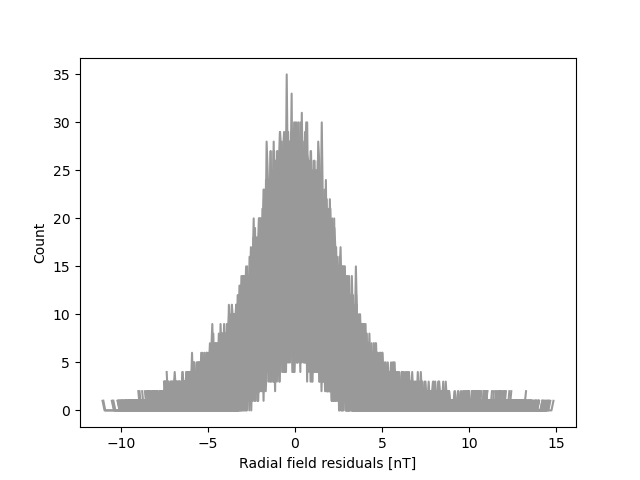

In [25]:
core.grid_glq(nmax = shn, r_at = core.r_cmb)

N_sim = 1000

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        obs_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [26]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shn)

# Evaluation

<IPython.core.display.Javascript object>


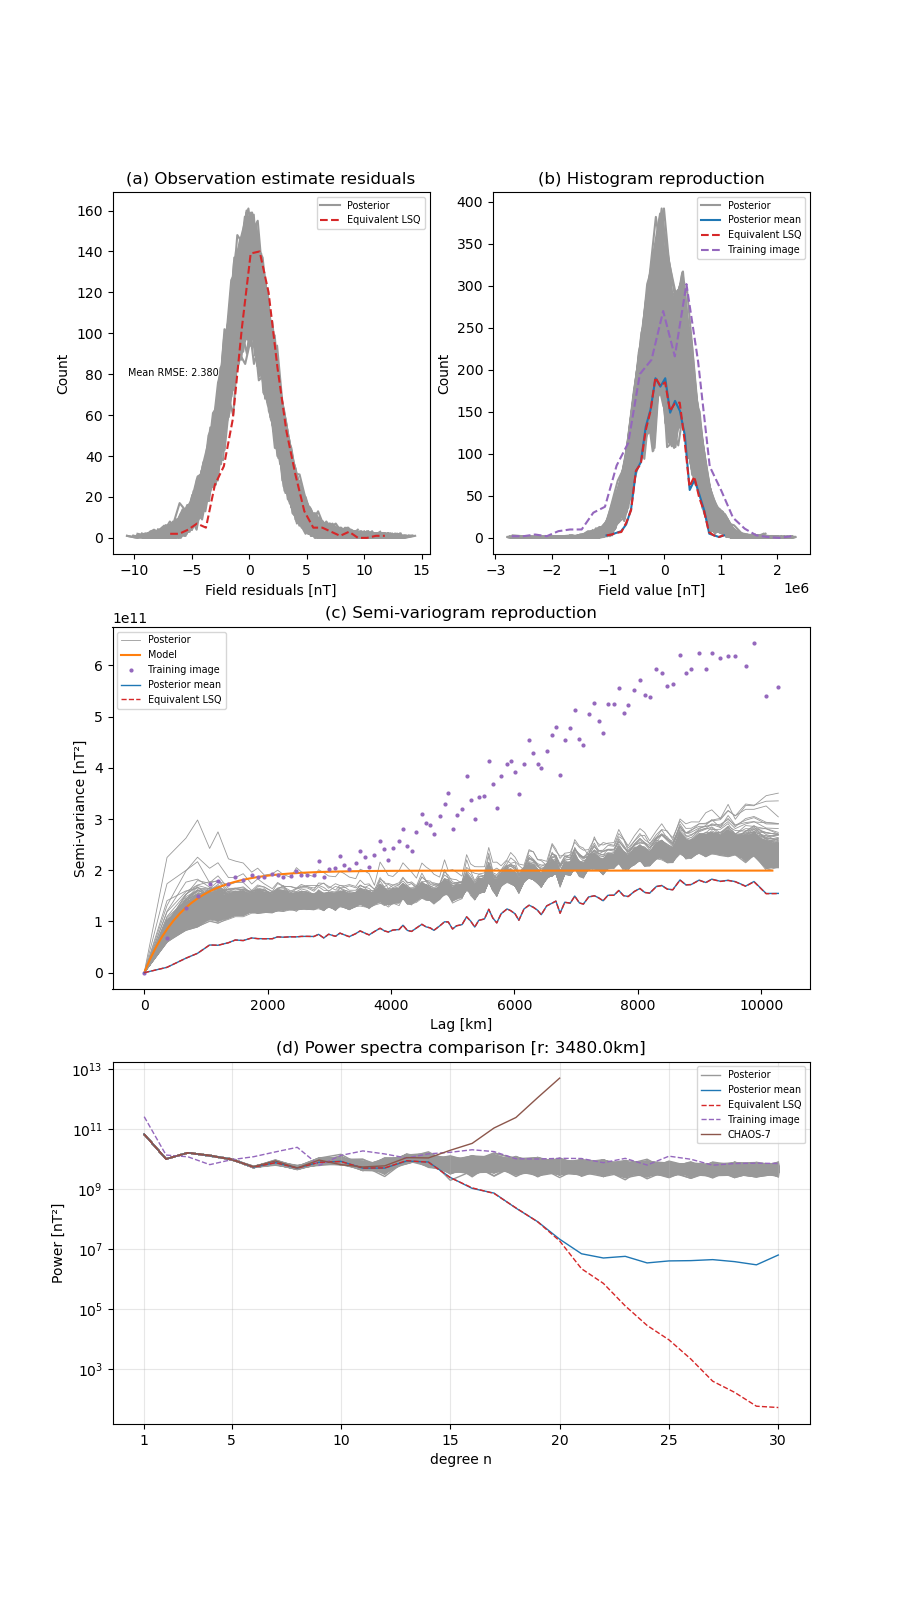

In [27]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shn, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {"CHAOS-7"}, figsize=(9,16), spec_chaos_time = [2016,1,1],
                              hist_bins = 25, res_bins = 25,
                              savefig = False, save_string = "vre_obs", save_dpi = 300)

In [32]:
skip = 1
m_skip = core.m_DSS[:,:][0::skip]
lat_skip = core.lat[0::skip]
lon_skip = core.lon[0::skip]


N_bins = 100
m_centers = []
m_y = []
for i in np.arange(0,m_skip.shape[0]):
    y,binEdges=np.histogram(m_skip[i,:],bins=N_bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    m_centers.append(bincenters)
    m_y.append(y)
    
m_centers = np.array(m_centers)
m_y = np.array(m_y)


deg_range = 1
lat_skip_lin = np.linspace(lat_skip-deg_range,lat_skip+deg_range,N_bins)
lon_skip_lin = np.linspace(lon_skip-2*deg_range,lon_skip+2*deg_range,N_bins)


m_y_scaled = []
for i in np.arange(0,m_skip.shape[0]):
    scale = np.min(lat_skip_lin[:,i]) + (m_y[i,:]-np.min(m_y[i,:]))*(np.max(lat_skip_lin[:,i])-np.min(lat_skip_lin[:,i]))/(np.max(m_y[i,:])-np.min(m_y[i,:]))

    m_y_scaled.append(scale)
    
m_y_scaled = np.array(m_y_scaled)

local_lat = m_y_scaled.reshape(-1,)
local_lon = lon_skip_lin.T.reshape(-1,)
local_data = m_centers.reshape(-1,)

<IPython.core.display.Javascript object>


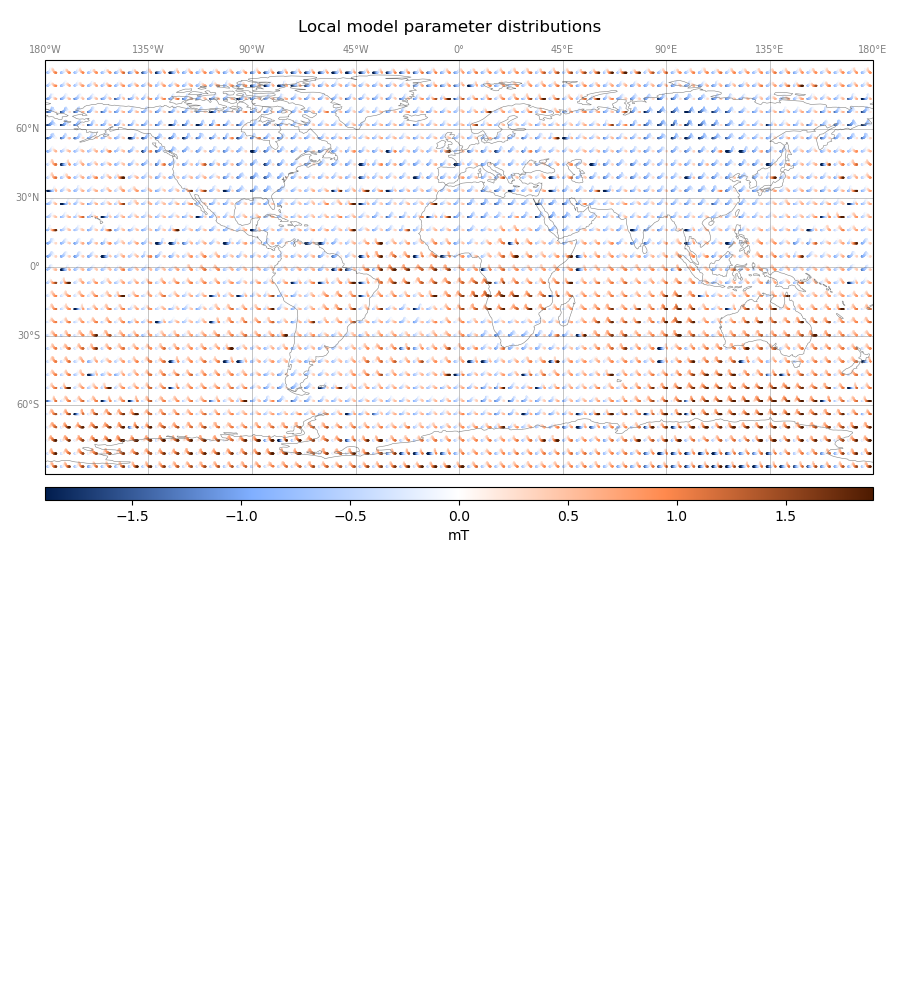

In [33]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, 
                cbar_h = 0.03, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(9,10), coast_width = 0.4,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.05,
                title='Local model parameter distributions', point_size=0.05, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string ="core_swarm_dqw",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [34]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)

set_nmax = shn

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


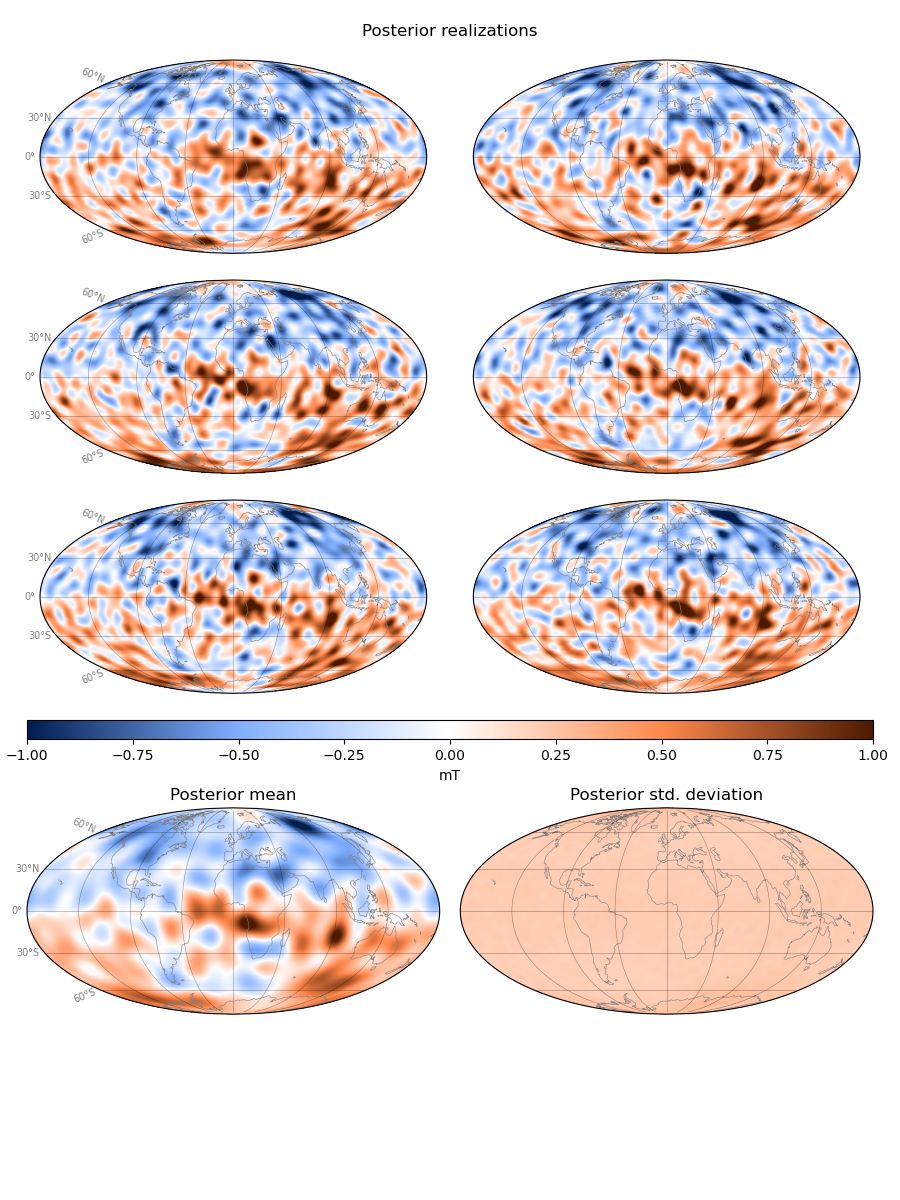

In [35]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa,
                        field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black", cbar_limit = [-1,1],
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.15, 
                        savefig = False, save_string = "vre_obs", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
